In [62]:
import numpy as np
import pandas as pd
from langchain_text_splitters import RecursiveCharacterTextSplitter
from pprint import pprint
import matplotlib.pyplot as plt

df = pd.read_json('data/preprocessed/reviews.jsonl', lines=True)

## Notes

* `semantic_text_splitter` looks at whitespace delimiters (`\n, .,` etc) for 'semantic' splitting. It can use a tokenizer but only to set chunk boundaries in terms of tokens rather than chars
* `semchunk` has a more elaborate ruleset for chunking but it is still based on whitespace and punctuation.
* LangChain's `SemanticChunker` embeds sentences using your chosen embedder, then breaks when cosine distance of the next sentence exceeds some boundary. So of the three this is the only truly semantic chunker. However, it **doesn't overlap chunks**.

In [70]:
from transformers import AutoTokenizer

bert_tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

In [71]:
def get_token_lengths(docs, tokenizer):
    return [len(ids) for ids in tokenizer(docs, padding=False, truncation=False).get("input_ids")]

def get_summary_stats(data: list[int|float]):
    arr = np.array(data)
    stats = {
        'count': len(arr),
        'mean': np.mean(arr),
        'median': np.median(arr),
        'std_dev': np.std(arr),
        'min': np.min(arr),
        'max': np.max(arr),
        '25th_percentile': np.percentile(arr, 25),
        '75th_percentile': np.percentile(arr, 75)
    }
    return stats

In [72]:
doc = df['body'].iloc[0]
print(type(doc))

<class 'str'>


### Semantic Text Splitter

In [87]:
from semantic_text_splitter import TextSplitter

# splitter = TextSplitter(capacity=1000, overlap=200)
splitter = TextSplitter((300, 1200), overlap=100)
chunks = splitter.chunks(doc)
print(f"Number of chunks: {len(chunks)}")

Number of chunks: 224


Chunk lengths (characters):
{'25th_percentile': np.float64(339.0),
 '75th_percentile': np.float64(452.0),
 'count': 224,
 'max': np.int64(735),
 'mean': np.float64(403.54910714285717),
 'median': np.float64(389.5),
 'min': np.int64(146),
 'std_dev': np.float64(81.97412102035587)}

Chunk lengths (tokens):
{'25th_percentile': np.float64(77.0),
 '75th_percentile': np.float64(104.0),
 'count': 224,
 'max': np.int64(181),
 'mean': np.float64(92.87053571428571),
 'median': np.float64(91.0),
 'min': np.int64(27),
 'std_dev': np.float64(20.838799399852572)}

Chunk lengths (words):
{'25th_percentile': np.float64(56.0),
 '75th_percentile': np.float64(74.25),
 'count': 224,
 'max': np.int64(108),
 'mean': np.float64(65.99553571428571),
 'median': np.float64(63.0),
 'min': np.int64(21),
 'std_dev': np.float64(13.81882055382168)}


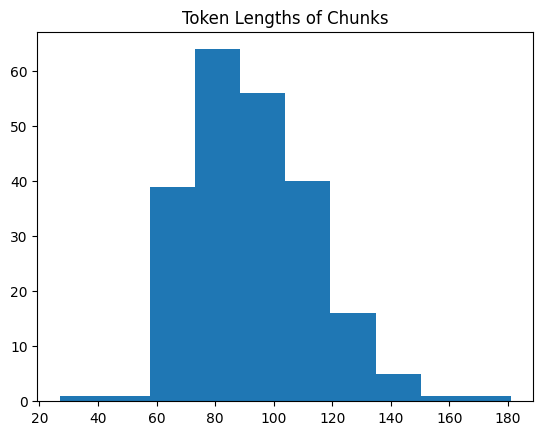

In [88]:
token_lengths = get_token_lengths(chunks, tokenizer)
wordcounts = [len(chunk.split()) for chunk in chunks]
charcounts = [len(chunk) for chunk in chunks]
print("Chunk lengths (characters):")
stats = get_summary_stats(charcounts)
pprint(stats)
print()
print("Chunk lengths (tokens):")
stats = get_summary_stats(token_lengths)
pprint(stats)
print()
print("Chunk lengths (words):")
stats = get_summary_stats(wordcounts)
pprint(stats)
plt.hist(token_lengths)
plt.title("Token Lengths of Chunks")
plt.show()

In [89]:
print(f"DOI: {df['doi'].iloc[0]}")
for i in range(3):
    print(f"Split {i}:")
    pprint(chunks[i])
    print()

DOI: 10.1016/j.newar.2024.101694
Split 0:
('1 Introduction Binary stars have long played a foundational role in '
 'astrophysics. They underpin precision measurements of stellar physical '
 'parameters, enable robust tests of general relativity, and give rise to an '
 'extraordinary zoo of observational phenomenology. Millennia after their '
 'discovery (e.g.')

Split 1:
('Millennia after their discovery (e.g. Jetsu and Porceddu, 2015 ), binaries '
 'remain at the heart of many of the interesting open questions in '
 'astrophysics: binary evolution modeling is key for understanding the origin '
 'of gravitational wave events, the spectral energy distributions of high '
 'redshift galaxies, and the demographics of exoplanets in the solar '
 'neighborhood.')

Split 2:
('Astrometry has played a particularly important role for binary star '
 'astronomy. Painstaking measurements of the relative positions of two stars '
 'in resolved optical pairs over the course of decades allowed Herschel 

### Semchunk

In [95]:
import semchunk

chunker = semchunk.chunkerify(bert_tokenizer, chunk_size=256)

Number of semchunks: 87
Chunk lengths (characters):
{'25th_percentile': np.float64(972.0),
 '75th_percentile': np.float64(1133.0),
 'count': 87,
 'max': np.int64(1244),
 'mean': np.float64(1025.6206896551723),
 'median': np.float64(1047.0),
 'min': np.int64(146),
 'std_dev': np.float64(156.94462317757802)}

Chunk lengths (tokens):
{'25th_percentile': np.float64(226.0),
 '75th_percentile': np.float64(249.0),
 'count': 87,
 'max': np.int64(258),
 'mean': np.float64(232.28735632183907),
 'median': np.float64(240.0),
 'min': np.int64(27),
 'std_dev': np.float64(31.07569847227414)}

Chunk lengths (words):
{'25th_percentile': np.float64(161.0),
 '75th_percentile': np.float64(182.0),
 'count': 87,
 'max': np.int64(206),
 'mean': np.float64(167.4712643678161),
 'median': np.float64(171.0),
 'min': np.int64(21),
 'std_dev': np.float64(24.477923002030384)}


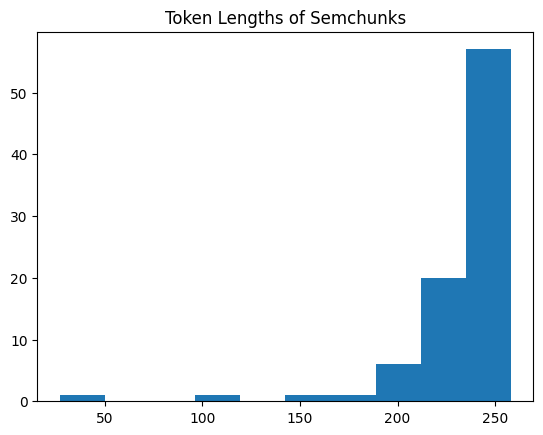

In [96]:
semchunks = chunker(doc)
print(f"Number of semchunks: {len(semchunks)}")

token_lengths = get_token_lengths(semchunks, tokenizer)
wordcounts = [len(chunk.split()) for chunk in semchunks]
charcounts = [len(chunk) for chunk in semchunks]
print("Chunk lengths (characters):")
stats = get_summary_stats(charcounts)
pprint(stats)
print()
print("Chunk lengths (tokens):")
stats = get_summary_stats(token_lengths)
pprint(stats)
print()
print("Chunk lengths (words):")
stats = get_summary_stats(wordcounts)
pprint(stats)
plt.hist(token_lengths)
plt.title("Token Lengths of Semchunks")
plt.show()

In [97]:
for i in range(3):
    print(f"Split {i}:")
    pprint(semchunks[i])
    print()

Split 0:
('1 Introduction Binary stars have long played a foundational role in '
 'astrophysics. They underpin precision measurements of stellar physical '
 'parameters, enable robust tests of general relativity, and give rise to an '
 'extraordinary zoo of observational phenomenology. Millennia after their '
 'discovery (e.g. Jetsu and Porceddu, 2015 ), binaries remain at the heart of '
 'many of the interesting open questions in astrophysics: binary evolution '
 'modeling is key for understanding the origin of gravitational wave events, '
 'the spectral energy distributions of high redshift galaxies, and the '
 'demographics of exoplanets in the solar neighborhood. Astrometry has played '
 'a particularly important role for binary star astronomy. Painstaking '
 'measurements of the relative positions of two stars in resolved optical '
 'pairs over the course of decades allowed Herschel (1803) to infer that most '
 'of the pairs he studied were orbiting one another. By monitoring the 

### SemanticChunker

In [102]:
from langchain_experimental.text_splitter import SemanticChunker
from langchain_huggingface import HuggingFaceEmbeddings

model_name = "bert-base-uncased"
hf_embeddings = HuggingFaceEmbeddings(
    model_name=model_name,
    model_kwargs={"device": "mps"},
    encode_kwargs={"normalize_embeddings": False},
    )

lc_splitter = SemanticChunker(
    embeddings=hf_embeddings,
    breakpoint_threshold_type="percentile",
    breakpoint_threshold_amount=95,
    min_chunk_size=64, # in chars
)

No sentence-transformers model found with name bert-base-uncased. Creating a new one with mean pooling.


In [103]:
splits = lc_splitter.split_text(doc)
print(f"Number of langchain splits: {len(splits)}")

Number of langchain splits: 26


Chunk lengths (characters):
{'25th_percentile': np.float64(770.0),
 '75th_percentile': np.float64(4929.25),
 'count': 26,
 'max': np.int64(10256),
 'mean': np.float64(3434.230769230769),
 'median': np.float64(2733.5),
 'min': np.int64(252),
 'std_dev': np.float64(2945.987274865361)}

Chunk lengths (tokens):
{'25th_percentile': np.float64(186.0),
 '75th_percentile': np.float64(1092.5),
 'count': 26,
 'max': np.int64(2340),
 'mean': np.float64(772.5769230769231),
 'median': np.float64(616.0),
 'min': np.int64(56),
 'std_dev': np.float64(652.2407043343221)}

Chunk lengths (words):
{'25th_percentile': np.float64(127.5),
 '75th_percentile': np.float64(805.0),
 'count': 26,
 'max': np.int64(1631),
 'mean': np.float64(560.3846153846154),
 'median': np.float64(450.0),
 'min': np.int64(39),
 'std_dev': np.float64(475.792705098399)}


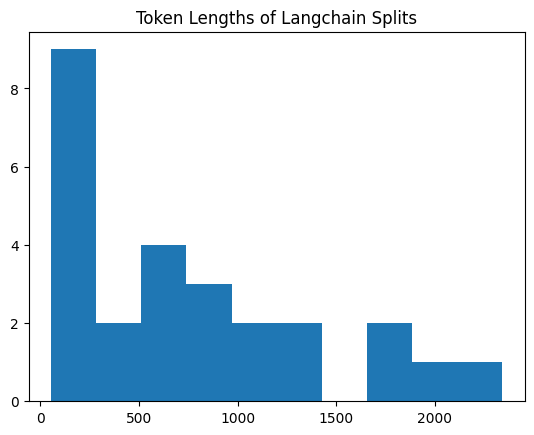

In [104]:
# Report statistics
token_lengths = get_token_lengths(splits, tokenizer)
wordcounts = [len(chunk.split()) for chunk in splits]
charcounts = [len(chunk) for chunk in splits]
print("Chunk lengths (characters):")
stats = get_summary_stats(charcounts)
pprint(stats)
print()
print("Chunk lengths (tokens):")
stats = get_summary_stats(token_lengths)
pprint(stats)
print()
print("Chunk lengths (words):")
stats = get_summary_stats(wordcounts)
pprint(stats)
plt.hist(token_lengths)
plt.title("Token Lengths of Langchain Splits")
plt.show()

In [105]:
for i in range(5):
    print(f"Langchain Split {i}:")
    pprint(splits[i])
    print()

Langchain Split 0:
('1 Introduction Binary stars have long played a foundational role in '
 'astrophysics. They underpin precision measurements of stellar physical '
 'parameters, enable robust tests of general relativity, and give rise to an '
 'extraordinary zoo of observational phenomenology. Millennia after their '
 'discovery (e.g. Jetsu and Porceddu, 2015 ), binaries remain at the heart of '
 'many of the interesting open questions in astrophysics: binary evolution '
 'modeling is key for understanding the origin of gravitational wave events, '
 'the spectral energy distributions of high redshift galaxies, and the '
 'demographics of exoplanets in the solar neighborhood. Astrometry has played '
 'a particularly important role for binary star astronomy. Painstaking '
 'measurements of the relative positions of two stars in resolved optical '
 'pairs over the course of decades allowed Herschel (1803) to infer that most '
 'of the pairs he studied were orbiting one another. By monit

In [106]:
grad_splitter = SemanticChunker(
    embeddings=hf_embeddings,
    breakpoint_threshold_type="gradient",
    breakpoint_threshold_amount=80.0,
    min_chunk_size=100,
)

grad_splits = grad_splitter.split_text(doc)
print(f"Number of langchain standard deviation splits: {len(grad_splits)}")

Number of langchain standard deviation splits: 116


Chunk lengths (characters):
{'25th_percentile': np.float64(770.0),
 '75th_percentile': np.float64(4929.25),
 'count': 26,
 'max': np.int64(10256),
 'mean': np.float64(3434.230769230769),
 'median': np.float64(2733.5),
 'min': np.int64(252),
 'std_dev': np.float64(2945.987274865361)}

Chunk lengths (tokens):
{'25th_percentile': np.float64(186.0),
 '75th_percentile': np.float64(1092.5),
 'count': 26,
 'max': np.int64(2340),
 'mean': np.float64(772.5769230769231),
 'median': np.float64(616.0),
 'min': np.int64(56),
 'std_dev': np.float64(652.2407043343221)}

Chunk lengths (words):
{'25th_percentile': np.float64(127.5),
 '75th_percentile': np.float64(805.0),
 'count': 26,
 'max': np.int64(1631),
 'mean': np.float64(560.3846153846154),
 'median': np.float64(450.0),
 'min': np.int64(39),
 'std_dev': np.float64(475.792705098399)}


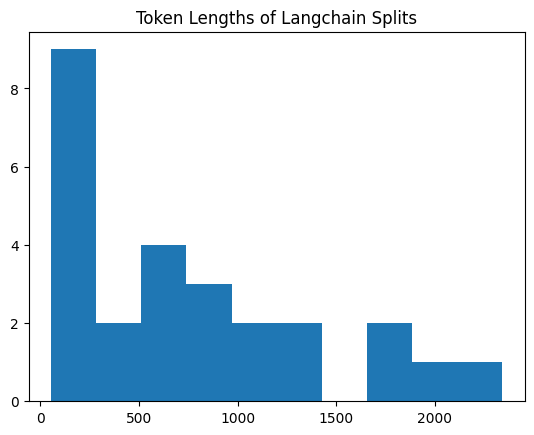

In [107]:
# Report statistics
token_lengths = get_token_lengths(splits, tokenizer)
wordcounts = [len(chunk.split()) for chunk in splits]
charcounts = [len(chunk) for chunk in splits]
print("Chunk lengths (characters):")
stats = get_summary_stats(charcounts)
pprint(stats)
print()
print("Chunk lengths (tokens):")
stats = get_summary_stats(token_lengths)
pprint(stats)
print()
print("Chunk lengths (words):")
stats = get_summary_stats(wordcounts)
pprint(stats)
plt.hist(token_lengths)
plt.title("Token Lengths of Langchain Splits")
plt.show()

In [108]:
for i in range(3):
    print(f"Langchain Split {i}:")
    pprint(grad_splits[i])
    print()

Langchain Split 0:
('1 Introduction Binary stars have long played a foundational role in '
 'astrophysics. They underpin precision measurements of stellar physical '
 'parameters, enable robust tests of general relativity, and give rise to an '
 'extraordinary zoo of observational phenomenology. Millennia after their '
 'discovery (e.g. Jetsu and Porceddu, 2015 ), binaries remain at the heart of '
 'many of the interesting open questions in astrophysics: binary evolution '
 'modeling is key for understanding the origin of gravitational wave events, '
 'the spectral energy distributions of high redshift galaxies, and the '
 'demographics of exoplanets in the solar neighborhood. Astrometry has played '
 'a particularly important role for binary star astronomy. Painstaking '
 'measurements of the relative positions of two stars in resolved optical '
 'pairs over the course of decades allowed Herschel (1803) to infer that most '
 'of the pairs he studied were orbiting one another. By monit

In [121]:
model_name = "BAAI/bge-large-en-v1.5"
bge_embeddings = HuggingFaceEmbeddings(
    model_name=model_name,
    model_kwargs={"device": "mps"},
    encode_kwargs={"normalize_embeddings": False},
)

bge_splitter = SemanticChunker(
    embeddings=bge_embeddings,
    breakpoint_threshold_type="percentile",
    breakpoint_threshold_amount=70,
    min_chunk_size=64,  # in chars
)

In [122]:
splits = bge_splitter.split_text(doc)
print(f"Number of langchain splits: {len(splits)}")

Number of langchain splits: 150


Token indices sequence length is longer than the specified maximum sequence length for this model (545 > 512). Running this sequence through the model will result in indexing errors


Chunk lengths (characters):
{'25th_percentile': np.float64(183.75),
 '75th_percentile': np.float64(735.25),
 'count': 150,
 'max': np.int64(5226),
 'mean': np.float64(594.44),
 'median': np.float64(392.0),
 'min': np.int64(66),
 'std_dev': np.float64(682.598959663237)}

Chunk lengths (tokens):
{'25th_percentile': np.float64(44.5),
 '75th_percentile': np.float64(166.75),
 'count': 150,
 'max': np.int64(1117),
 'mean': np.float64(135.56666666666666),
 'median': np.float64(91.5),
 'min': np.int64(19),
 'std_dev': np.float64(145.86086597241297)}

Chunk lengths (words):
{'25th_percentile': np.float64(31.25),
 '75th_percentile': np.float64(123.75),
 'count': 150,
 'max': np.int64(808),
 'mean': np.float64(97.13333333333334),
 'median': np.float64(64.0),
 'min': np.int64(10),
 'std_dev': np.float64(107.94583003628358)}


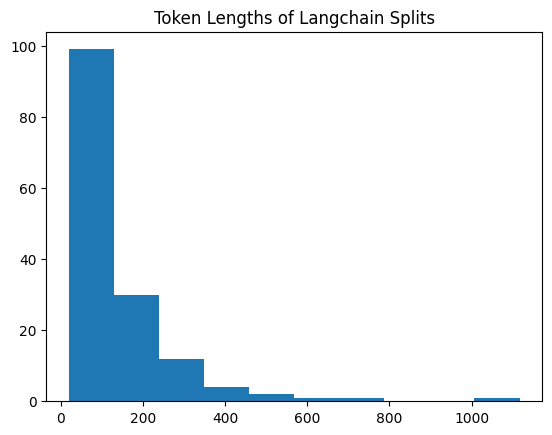

In [123]:
# Report stats
tokenizer = AutoTokenizer.from_pretrained(model_name)
token_lengths = get_token_lengths(splits, tokenizer)
wordcounts = [len(chunk.split()) for chunk in splits]
charcounts = [len(chunk) for chunk in splits]
print("Chunk lengths (characters):")
stats = get_summary_stats(charcounts)
pprint(stats)
print()
print("Chunk lengths (tokens):")
stats = get_summary_stats(token_lengths)
pprint(stats)
print()
print("Chunk lengths (words):")
stats = get_summary_stats(wordcounts)
pprint(stats)
plt.hist(token_lengths)
plt.title("Token Lengths of Langchain Splits")
plt.show()


In [124]:
for i in range(3):
    print(f"Langchain Split {i}:")
    pprint(splits[i])
    print()

Langchain Split 0:
('1 Introduction Binary stars have long played a foundational role in '
 'astrophysics. They underpin precision measurements of stellar physical '
 'parameters, enable robust tests of general relativity, and give rise to an '
 'extraordinary zoo of observational phenomenology. Millennia after their '
 'discovery (e.g. Jetsu and Porceddu, 2015 ), binaries remain at the heart of '
 'many of the interesting open questions in astrophysics: binary evolution '
 'modeling is key for understanding the origin of gravitational wave events, '
 'the spectral energy distributions of high redshift galaxies, and the '
 'demographics of exoplanets in the solar neighborhood. Astrometry has played '
 'a particularly important role for binary star astronomy. Painstaking '
 'measurements of the relative positions of two stars in resolved optical '
 'pairs over the course of decades allowed Herschel (1803) to infer that most '
 'of the pairs he studied were orbiting one another. By monit